question: how to overcome stationarity? 

question: multi-step forward prediction -- https://machinelearningmastery.com/multi-step-time-series-forecasting/

question: question why stateful?

## Define Hyper-Parameters

In [ ]:
%matplotlib notebook

In [1]:
'''
LSTM playground
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
trainingParams = {}
trainingParams['batchSize'] = 128
trainingParams['unrolledTimesteps'] = 100
trainingParams['inputDimensionality'] = 1
trainingParams['forwardSamplesToPredict'] = 10

trainingParams['trainEpochs'] = 100

## Generate Target Dataset

In [13]:
xRange = np.linspace(start=0, stop=25*np.pi, num=2500000)
targetData = np.cos( xRange ) * xRange/10

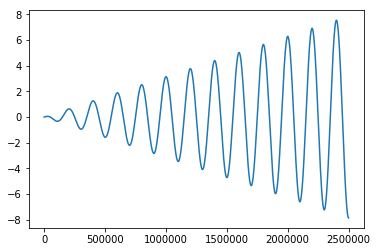

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot( targetData )
plt.show()

## Generate Training Matrix -- Input/Output Batches
aka sequences subsampling -- break up big sequence into batches of unrolled timestep duration

In [20]:
def get_batched_data(inputData, trainingParams):
    
    if len(inputData.shape) == 1:
        inputData = np.expand_dims( inputData, 1)

    RNNBatchSamples = int ( trainingParams['batchSize'] * trainingParams['unrolledTimesteps'] )
    totalBatchesInDataset = int ( len(inputData) / RNNBatchSamples )
    
    batchedInputMatrix = np.zeros( ( int(totalBatchesInDataset), 
                                    int(trainingParams['batchSize']), 
                                    int(trainingParams['unrolledTimesteps']), 
                                    int(trainingParams['inputDimensionality']) ) )
    
    batchedOutputMatrix = np.zeros ( ( int(totalBatchesInDataset),
                                      int(trainingParams['batchSize']),
                                      int(trainingParams['forwardSamplesToPredict'])))
    
    
    for iInputDimension in range ( trainingParams['inputDimensionality'] ):
        for iBatch in range( totalBatchesInDataset ):
            startIndex = iBatch * RNNBatchSamples
            endIndex = startIndex + RNNBatchSamples

            batchedInputMatrix[iBatch, :, :, iInputDimension] = np.reshape( inputData[ startIndex:endIndex, iInputDimension ],
                                                                           ( trainingParams['batchSize'],
                                                                            trainingParams['unrolledTimesteps']) )
            # within a batch
            for iBatchElement in range ( trainingParams['batchSize'] ):
                batchElementEnd = startIndex + trainingParams['unrolledTimesteps'] * (iBatchElement+1)
                batchElementPredictedTarget = batchElementEnd + trainingParams['forwardSamplesToPredict']                
                batchedOutputMatrix[iBatch, iBatchElement ] = inputData[ batchElementEnd : batchElementPredictedTarget].flatten()
    
    return batchedInputMatrix, batchedOutputMatrix

In [21]:
batchedInputMatrix, batchedOutputMatrix = get_batched_data ( targetData, trainingParams )

In [22]:
batchedInputMatrix.shape

(195, 128, 100, 1)

In [23]:
batchedOutputMatrix.shape

(195, 128, 10)

In [24]:
batchedInputMatrix[0,0]

array([[0.00000000e+00],
       [3.14159391e-06],
       [6.28318781e-06],
       [9.42478169e-06],
       [1.25663755e-05],
       [1.57079694e-05],
       [1.88495631e-05],
       [2.19911568e-05],
       [2.51327505e-05],
       [2.82743441e-05],
       [3.14159376e-05],
       [3.45575309e-05],
       [3.76991242e-05],
       [4.08407174e-05],
       [4.39823105e-05],
       [4.71239034e-05],
       [5.02654962e-05],
       [5.34070889e-05],
       [5.65486813e-05],
       [5.96902737e-05],
       [6.28318658e-05],
       [6.59734578e-05],
       [6.91150495e-05],
       [7.22566411e-05],
       [7.53982324e-05],
       [7.85398235e-05],
       [8.16814144e-05],
       [8.48230051e-05],
       [8.79645955e-05],
       [9.11061856e-05],
       [9.42477754e-05],
       [9.73893650e-05],
       [1.00530954e-04],
       [1.03672543e-04],
       [1.06814132e-04],
       [1.09955720e-04],
       [1.13097308e-04],
       [1.16238896e-04],
       [1.19380484e-04],
       [1.22522071e-04],


In [10]:
batchedOutputMatrix[0,0]

array([0.03140055, 0.03171424, 0.03202792, 0.03234159, 0.03265526,
       0.03296891, 0.03328255, 0.03359619, 0.03390981, 0.03422342])

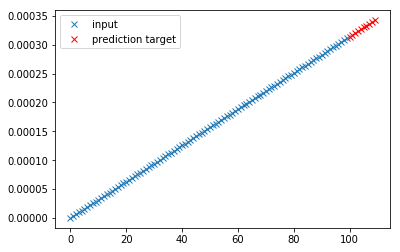

In [25]:
plt.figure()
inputData = batchedInputMatrix[0, 0]
targetData = batchedOutputMatrix[0, 0]
plt.plot(np.arange(len(inputData)), inputData, 'x')
plt.plot(np.arange(len(inputData),len(inputData)+len(targetData)), targetData, 'xr')
plt.legend(['input','prediction target'])
plt.show()

## Define Model Architecture

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

## Model Statefulness (from Keras documentation)

<b>Note on using statefulness in RNNs</b> -- source: https://keras.io/layers/recurrent/

You can set RNN layers to be 'stateful', which means that the states computed for the samples in one batch will be reused as initial states for the samples in the next batch. This assumes a one-to-one mapping between samples in different successive batches.

To enable statefulness: - specify stateful=True in the layer constructor. - specify a fixed batch size for your model, by passing if sequential model: batch_input_shape=(...) to the first layer in your model. else for functional model with 1 or more Input layers: batch_shape=(...) to all the first layers in your model. This is the expected shape of your inputs including the batch size. It should be a tuple of integers, e.g. (32, 10, 100). - specify shuffle=False when calling fit().

To reset the states of your model, call .reset_states() on either a specific layer, or on your entire model.


## Simple Dense Model

In [ ]:
print('creating model')
simpleDenseModel = Sequential()

# lstm layer
simpleDenseModel.add( Dense( 10, input_dim=trainingParams['unrolledTimesteps']))

# output layer
simpleDenseModel.add( Dense( trainingParams['forwardSamplesToPredict'], activation='linear') )

# compile
simpleDenseModel.compile(loss='mse', optimizer='adam')

## Simple non-Stateful LSTM Model

In [ ]:
print('creating model')
simpleNonStatefulModel = Sequential()

# lstm layer
simpleNonStatefulModel.add( LSTM( 10,
                batch_input_shape = ( trainingParams['batchSize'], 
                                      trainingParams['unrolledTimesteps'],
                                      trainingParams['inputDimensionality'] ),
                return_sequences = False, # needed in case we stack LSTM layers
                stateful = False ) ) 
# dense layer
simpleNonStatefulModel.add( Dense( 10, activation='sigmoid') )

# output layer
simpleNonStatefulModel.add( Dense( trainingParams['forwardSamplesToPredict'], activation='linear') )

# compile
simpleNonStatefulModel.compile(loss='mse', optimizer='adam')

## Simple Stateful Model

In [ ]:
print('creating model')
simpleStatefulModel = Sequential()

# lstm layer
simpleStatefulModel.add( LSTM( 10,
                batch_input_shape = ( trainingParams['batchSize'], 
                                      trainingParams['unrolledTimesteps'],
                                      trainingParams['inputDimensionality'] ),
                return_sequences = False, # needed in case we stack LSTM layers
                stateful = True ) ) 
# dense layer
simpleStatefulModel.add( Dense( 10, activation='sigmoid') )

# output layer
simpleStatefulModel.add( Dense( trainingParams['forwardSamplesToPredict'], activation='linear') )

# compile
simpleStatefulModel.compile(loss='mse', optimizer='adam')

## Complex* Stateful Model

In [26]:
print('creating model')
complexStatefulModel = Sequential()

# lstm layer
complexStatefulModel.add( LSTM( 35,
                batch_input_shape = ( trainingParams['batchSize'], 
                                      trainingParams['unrolledTimesteps'],
                                      trainingParams['inputDimensionality'] ),
                return_sequences = True, # needed in case we stack LSTM layers
                stateful = True ) ) 
complexStatefulModel.add( Dropout(.2) )

# 2nd lstm layer
complexStatefulModel.add( LSTM( 35 ))
complexStatefulModel.add( Dropout(.2) )

# dense layer
complexStatefulModel.add( Dense( 20, activation='sigmoid') )
complexStatefulModel.add( Dropout(.2) )

# output layer
complexStatefulModel.add( Dense( trainingParams['forwardSamplesToPredict'], activation='linear') )

# compile
complexStatefulModel.compile(loss='mse', optimizer='adam')

creating model


## Select Model

In [28]:
#denseNet = True
#model = simpleDenseModel

denseNet = False
model = complexStatefulModel



## Training Loop

In [ ]:
# !pip install sklearn

In [29]:
early_stopping = EarlyStopping( monitor = 'val_loss', patience = 15)
checkpointer = ModelCheckpoint( filepath = 'best_weights.hdf5', verbose = 0, save_best_only = True)

if denseNet:
    inputMatrix = batchedInputMatrix.squeeze()
else:
    inputMatrix = batchedInputMatrix

from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split( inputMatrix, batchedOutputMatrix, test_size=0.33, random_state=42, shuffle=False)


In [30]:
batchedOutputMatrix.shape

(195, 128, 10)

In [31]:
xTrain.shape

(130, 128, 100, 1)

In [32]:
yTrain.shape

(130, 128, 10)

In [ ]:
print('training initiated')
NBatches = xTrain.shape[0]

lossHistory = np.zeros((trainingParams['trainEpochs'],1))

for iEpoch in range( trainingParams['trainEpochs'] ):
    print( 'epoch ', iEpoch, ' / ', trainingParams['trainEpochs'])
    
    batchLoss = 0
    for iBatch in range (  NBatches ):        
        history = model.fit( xTrain[iBatch], yTrain[iBatch], 
                   batch_size = trainingParams['batchSize'],                            
                   verbose = 0,
                   nb_epoch = 1, 
                   shuffle=False,
                   callbacks = [early_stopping, checkpointer],
                   validation_data = (xTest[0], yTest[0]) )
        
        batchLoss += history.history['loss'][0]
        
    lossHistory[iEpoch] = batchLoss/NBatches
    print('average batch loss: ', lossHistory[iEpoch])
    
    model.reset_states()

In [35]:
# load best weights
model.load_weights("best_weights.hdf5")
model.compile(optimizer = 'adam', loss = 'mse') # need to recompile model to be able to run prediction

## Learning Curve

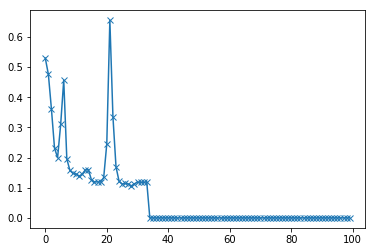

In [34]:
plt.figure()
plt.plot(lossHistory,'-x')
plt.show()

## Evaluating Model Quality

In [36]:
if denseNet:
    inputMatrix = batchedInputMatrix.squeeze()
else:
    inputMatrix = batchedInputMatrix

## Single Prediction

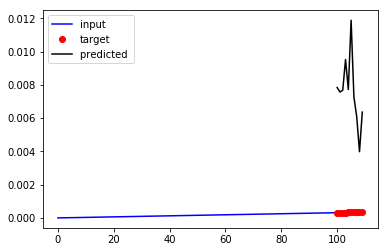

In [42]:
iBatch = 0
iBatchElement = 0

currentPredictions = model.predict(inputMatrix[iBatch], batch_size=trainingParams['batchSize'])
inputData = batchedInputMatrix[iBatch, iBatchElement]
targetData = batchedOutputMatrix[iBatch, iBatchElement]
predictedData = currentPredictions[iBatchElement]

plt.figure()
plt.plot(np.arange(len(inputData)) , inputData, 'b')
plt.plot(np.arange(len(inputData), len(inputData)+len(targetData) ) , targetData, 'ro')
plt.plot(np.arange(len(inputData), len(inputData)+len(targetData) ) , predictedData, 'k')
plt.legend(['input','target', 'predicted '])
    
plt.show()

## Batched Prediction

In [ ]:
batchNum = 0
batchElement = 0

plt.figure()
offset = 0
NBatches = batchedInputMatrix.shape[0]
for iBatch in range ( 20 ):
    currentPredictions = model.predict(inputMatrix[iBatch], batch_size=trainingParams['batchSize'])

    for iBatchElement in range( trainingParams['batchSize']):
        inputData = batchedInputMatrix[iBatch, iBatchElement]
        targetData = batchedOutputMatrix[iBatch, iBatchElement]
        predictedData = currentPredictions[iBatchElement]

        plt.plot(np.arange(len(inputData)) + offset, inputData, 'b')
        plt.plot(np.arange(len(inputData), len(inputData)+len(targetData) )+ offset, targetData, 'ro')
        plt.plot(np.arange(len(inputData), len(inputData)+len(targetData) )+ offset, predictedData, 'k')
        offset += len(inputData)
        plt.legend(['input','target', 'predicted '])
    
plt.show()